# Using TrAdaBoost for improving model fairness

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.stats import kstest
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [2]:
from transformers.features_missing_vals import imputation_pipeline
from transformers.ethnic_groups import CombineEthnicGroups

In [3]:
from transfer_learning.TrAdaBoost import TrAdaBoost
from model_evaluation.metrics import plot_roc_curves
from univariate.schools_comparison import plot_distribution
from univariate.schools_comparison import plot_two_bars

# Params

In [4]:
source_school = 'ULSA'
target_school = 'UENG'

In [5]:
# Model features for Asian students
cols_asian = ['STDNT_FEMALE',
              'STDNT_AGE_BIN',
              'HS_GPA_Imp_Interp',
              'CURR_GPA',
              'HS_CALC_IND',
              'GROSS_FAM_INC',
              'SNGL_PRNT_IND',
              #'STDNT_ETHNC_GRP_CD',
              'SAT_ACT_TOTAL_BIN',
              'PRNT_ED_LVL',
              'No_grades_at_all',
              'Grade_Overall_I_for_1_and_more_courses',
              'Grade_W_for_1_course',
              'Grade_W_for_2_courses',
              'Grade_W_for_3_and_more_courses',
              'Grade_NR_for_1_and_more_courses']

In [6]:
# Model features for student groups other than White and Asian
cols_other = ['STDNT_FEMALE',
              'STDNT_AGE_BIN',
              'HS_GPA_Imp_Interp',
              'CURR_GPA',
              'HS_CALC_IND',
              'GROSS_FAM_INC',
              'SNGL_PRNT_IND',
              #'STDNT_ASIAN_IND',
              'STDNT_BLACK_IND',
              'STDNT_HSPNC_IND',
              'STDNT_NTV_AMRCN_HWIAN_IND',
              'STDNT_MULTI_ETHNC_IND',
              'STDNT_ETHNC_NAN',
              'SAT_ACT_TOTAL_BIN',
              'PRNT_ED_LVL',
              'No_grades_at_all',
              'Grade_Overall_I_for_1_and_more_courses',
              'Grade_W_for_1_course',
              'Grade_W_for_2_courses',
              'Grade_W_for_3_and_more_courses',
              'Grade_NR_for_1_and_more_courses']

In [7]:
random_state = 1

In [8]:
clf = LogisticRegression(penalty=None, random_state=random_state, max_iter=10000)

# Data

In [9]:
features_df = pd.read_csv('features_df.csv', low_memory=False)
source_df = features_df[features_df['PRMRY_CRER_CD']==source_school].copy()
target_df = features_df[features_df['PRMRY_CRER_CD']==target_school].copy()

# Reset target index to ensure that cross-validation indices will be accurately applied
target_df.reset_index(drop=True, inplace=True)

In [ ]:
# Group together all ethnic groups, excluding white and asian populations, as they lack a sufficient 
# number of dropouts for a meaningful fairness analysis

# Add new column 'STDNT_ETHNC_grouped' with the following values: 0 for white, 1 for asian, and 2 for other
combine_transformer = CombineEthnicGroups()
target_df = combine_transformer.fit_transform(target_df)

target_df.groupby('STDNT_ETHNC_grouped')[['y_ENROLLED_1_YEAR_LATER']].agg(['count', 'sum'])

In [11]:
# Impute missing values and apply WoE transformation for the direct transfer
source_df = combine_transformer.fit_transform(source_df)
source_imp = imputation_pipeline.fit_transform(source_df, source_df['y_ENROLLED_1_YEAR_LATER'])
target_imp = imputation_pipeline.transform(target_df)

# Model for Asian students
The earlier analysis showed a significant difference in accuracy between the model's performance for Asian and White students, primarily due to the smaller sample size of Asian students. To address this inequality, a potential solution is to create a model specifically for Asian students. However, data limitations prevent the development of a separate model for Asian students (only 61 dropout cases in the source data for Asian students).

An alternative is to apply a transfer learning approach, specifically TrAdaBoost. This method allows the usage of all data points in the source dataset, assigning lower weights to non-Asian students to better represent the characteristics of Asian students.

Given the small number of Asian student dropouts in the source data (only 61 cases), testing TrAdaBoost on the source data is impractical. Instead, a possible strategy is to use a subset of Asian students from the target university data for testing.

However, before proceeding, it is important to assess the similarity between Asian students in the source and target datasets. Only if they show sufficient similarity, Asian students from the target data can form a good testing sample for the TrAdaBoost model developed on the source data.

## Evaluating the similarity between Asian students in the source dataset and those in the target dataset

### Examining the similarity of dropout rates

In [ ]:
# Dropout rate for Asian students in the source dataset
source_df.loc[source_df['STDNT_ETHNC_grouped']==1, 'y_ENROLLED_1_YEAR_LATER'].mean()

In [ ]:
# Dropout rate for Asian students in the target dataset
target_df.loc[target_df['STDNT_ETHNC_grouped']==1, 'y_ENROLLED_1_YEAR_LATER'].mean()

### Evaluating the similarity of factor distributions

#### Current GPA distribution

In [ ]:
plot_distribution(features_df[features_df['STDNT_ETHNC_GRP_CD']==4], 
                  source_school, target_school, 'CURR_GPA', 15, 
                  'Comparison of the current GPA distributions for Asian students')

#### Parent education level

In [ ]:
plot_two_bars(features_df[features_df['STDNT_ETHNC_GRP_CD']==4], 
              source_school, target_school, 'PRNT_ED_LVL', 
              'Parent educational level for Asian students')

#### Family income

In [ ]:
plot_two_bars(features_df[features_df['STDNT_ETHNC_GRP_CD']==4], 
              source_school, target_school, 'GROSS_FAM_INC', 
              'Gross family income for Asian students')

The comparable dropout rates and similar distribution of factors make the subset of Asian students in the target set a suitable choice for testing a model developed for Asian students based on the source dataset.

## Direct transfer

In [17]:
# Fit the source model
clf_source = clone(clf)
clf_source.fit(source_imp[cols_asian], source_imp['y_ENROLLED_1_YEAR_LATER'])

LogisticRegression(max_iter=10000, penalty=None, random_state=1)

### Testing AUC on the target dataset for a subsample of Asian students

In [18]:
y_pred = clf_source.predict_proba(target_imp.loc[target_df['STDNT_ETHNC_grouped']==1, cols_asian])

In [19]:
# DataFrame containing true and predicted y
df_true_predict_direct = pd.DataFrame(
    data={'y': target_imp.loc[target_df['STDNT_ETHNC_grouped']==1, 'y_ENROLLED_1_YEAR_LATER'],
          'y_pred': y_pred[:,1]}
)

In [20]:
roc_auc_score(df_true_predict_direct['y'], df_true_predict_direct['y_pred'])

0.7383975164282953

## Using TrAdaBoost to create a model tailored specifically for Asian students
The model for Asian students is builded using the source university dataset, with the Asian subsample serving as the target dataset and the remaining students forming the source dataset.

In [21]:
clf_TrAdaBoost = clone(clf)
TrAdaBoost_model = TrAdaBoost(estimator=clf_TrAdaBoost, max_num_iterations=10)

In [22]:
TrAdaBoost_model.fit(source_imp[cols_asian], 
                     source_imp['y_ENROLLED_1_YEAR_LATER'], 
                     source_indices=source_df[source_df['STDNT_ETHNC_grouped']!=1].index) # Not Asian students indices

TrAdaBoost(estimator=LogisticRegression(max_iter=10000, penalty=None,
                                        random_state=1),
           max_num_iterations=10)

### Testing AUC on the target dataset for a subsample of Asian students

In [23]:
y_pred = TrAdaBoost_model.predict_proba(target_imp.loc[target_df['STDNT_ETHNC_grouped']==1, cols_asian])
y_pred = y_pred.to_numpy()

In [24]:
# DataFrame containing true and predicted y
df_true_predict_TrAdaBoost = pd.DataFrame(
    data={'y': target_imp.loc[target_df['STDNT_ETHNC_grouped']==1, 'y_ENROLLED_1_YEAR_LATER'],
          'y_pred': y_pred}
)

In [25]:
roc_auc_score(df_true_predict_TrAdaBoost['y'], df_true_predict_TrAdaBoost['y_pred'])

0.7902312040974102

## Comparison of ROC curves

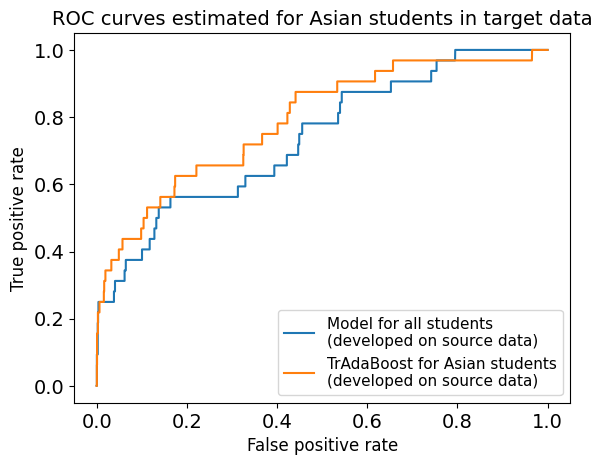

In [26]:
plot_roc_curves(df_true_predict_direct, df_true_predict_TrAdaBoost,
                'Model for all students\n(developed on source data)', 
                'TrAdaBoost for Asian students\n(developed on source data)', 
                'ROC curves estimated for Asian students in target data')

# Model for other students (non-White and non-Asian students)

## Evaluating the similarity between other students in the source dataset and those in the target dataset

### Dropout rate

In [ ]:
# Dropout rate for other students in the source dataset
source_df.loc[source_df['STDNT_ETHNC_grouped']==2, 'y_ENROLLED_1_YEAR_LATER'].mean()

In [ ]:
# Dropout rate for other students in the target dataset
target_df.loc[target_df['STDNT_ETHNC_grouped']==2, 'y_ENROLLED_1_YEAR_LATER'].mean()

### Distribution of ethnic groups

In [29]:
dic = {1: 'White', 2: 'Black', 3: 'Hispanic', 
       4: 'Asian', 5: 'Native Amr\nHawaiian', 6: 'Not Indic', 
       7: 'Hawaiian', 0: '2 or More'}
col = 'STDNT_ETHNC_GRP_CD'

In [30]:
# Source disribution
source_df[col] = source_df[col].map(dic)
bar = source_df[source_df['STDNT_ETHNC_grouped']==2].groupby(col)[['y_ENROLLED_1_YEAR_LATER']].agg(['count'])
bar.columns = bar.columns.droplevel()
bar['count'] = bar['count'] / bar['count'].sum()
bar=bar.loc[['Hispanic', 'Black', 'Not Indic', 'Native Amr\nHawaiian', '2 or More']]

In [31]:
# Target distribution
target_df[col] = target_df[col].map(dic)
bar1 = target_df[target_df['STDNT_ETHNC_grouped']==2].groupby(col)[['y_ENROLLED_1_YEAR_LATER']].agg(['count'])
bar1.columns = bar1.columns.droplevel()
bar1['count'] = bar1['count'] / bar1['count'].sum()
bar1=bar1.loc[['Hispanic', 'Black', 'Not Indic', 'Native Amr\nHawaiian', '2 or More']]

In [ ]:
x_axis = np.arange(len(bar.index))
plt.bar(x_axis-0.2, bar['count'], width=0.4, label='Source data - ULSA')
plt.bar(x_axis+0.2, bar1['count'], width=0.4, label='Target data - UENG')

plt.legend()
plt.xticks(x_axis, bar.index)

plt.title("Distribution of ethnic groups in student subset 'Other'\n(non-White and non-Asian students)", fontsize=14)
plt.xlabel('Ethnic group', fontsize=12)
plt.ylabel('Percent', fontsize=12);

The difference in dropout rates and in ethnic composition of the 'other' student group between the target and source sets makes  the subset of other students in the target data unsuitable for testing the model developed for the other student group on the source dataset.

## Direct transfer

In [33]:
# Fit the source model
clf_source = clone(clf)
clf_source.fit(source_imp[cols_other], source_imp['y_ENROLLED_1_YEAR_LATER'])

LogisticRegression(max_iter=10000, penalty=None, random_state=1)

### Testing AUC on the target dataset for a subsample of other students

In [34]:
y_pred = clf_source.predict_proba(target_imp.loc[target_df['STDNT_ETHNC_grouped']==2, cols_other])

In [35]:
# DataFrame containing true and predicted y
df_true_predict_direct = pd.DataFrame(
    data={'y': target_imp.loc[target_df['STDNT_ETHNC_grouped']==2, 'y_ENROLLED_1_YEAR_LATER'],
          'y_pred': y_pred[:,1]}
)

In [36]:
roc_auc_score(df_true_predict_direct['y'], df_true_predict_direct['y_pred'])

0.7857764538589782

## Using TrAdaBoost to create a model tailored specifically for other students
The model for other students is builded using the source university dataset, with the other students subsample serving as the target dataset and the remaining students forming the source dataset.

In [37]:
clf_TrAdaBoost = clone(clf)
TrAdaBoost_model = TrAdaBoost(estimator=clf_TrAdaBoost, max_num_iterations=10)

In [38]:
TrAdaBoost_model.fit(source_imp[cols_other], 
                     source_imp['y_ENROLLED_1_YEAR_LATER'], 
                     source_indices=source_df[source_df['STDNT_ETHNC_grouped']!=2].index)

TrAdaBoost(estimator=LogisticRegression(max_iter=10000, penalty=None,
                                        random_state=1),
           max_num_iterations=10)

### Testing AUC on the target dataset for a subsample of other students

In [39]:
y_pred = TrAdaBoost_model.predict_proba(target_imp.loc[target_df['STDNT_ETHNC_grouped']==2, cols_other])
y_pred = y_pred.to_numpy()

In [40]:
# DataFrame containing true and predicted y
df_true_predict_TrAdaBoost = pd.DataFrame(
    data={'y': target_imp.loc[target_df['STDNT_ETHNC_grouped']==2, 'y_ENROLLED_1_YEAR_LATER'],
          'y_pred': y_pred}
)

In [41]:
roc_auc_score(df_true_predict_TrAdaBoost['y'], df_true_predict_TrAdaBoost['y_pred'])

0.8115560949298813

## Comparison of ROC curves

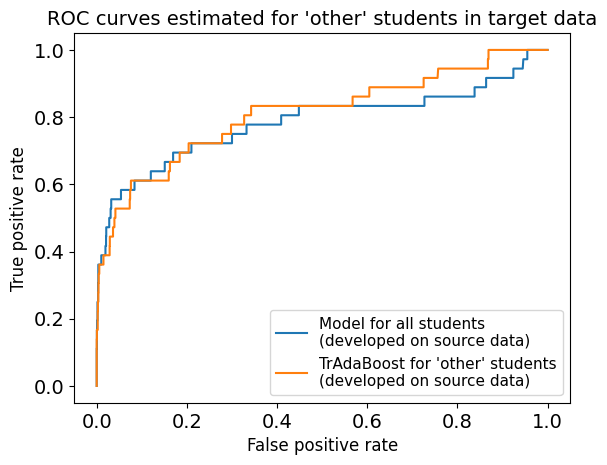

In [42]:
plot_roc_curves(df_true_predict_direct, df_true_predict_TrAdaBoost,
                'Model for all students\n(developed on source data)', 
                "TrAdaBoost for 'other' students\n(developed on source data)", 
                "ROC curves estimated for 'other' students in target data")